In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite 
import csv
import itertools
%matplotlib inline

In [2]:
db_data = pd.read_csv("uniprotlinks.csv")
unip_data = pd.read_csv("uniprot-all2.csv")

In [3]:
df = db_data.rename(columns={'Name': 'Drug Name', 'UniProt Name': 'Protein Name'})
df_2 = unip_data.rename(columns={'Entry': 'UniProt ID', 'Protein names': 'Protein Name', 'Gene names': 'Gene Symbol'})

In [4]:
##Chaning the type of column "Gene Symbol" to list. 
Gene_sym = df_2["Gene Symbol"].tolist()

##Splitting data into list of lists using space delimiter. 
what_i_want = []
for id_ in Gene_sym:
    temp = str(id_).split(' ')
    what_i_want.append(temp)
    
#Trimming off Gene Symbol Aliases 

what_i_actually_want = [id_pair[0] for id_pair in what_i_want]  ##list comprehensions 
    

In [5]:
s = pd.Series(what_i_actually_want)  ##turning the list of values into a series.
df_2['Gene Symbol'] = s.values   ##adding that series to the dataframe. 

In [6]:
##Using merge to merge two dataframes and map the UniProt Id to Gene Symbol. 

combined_df = db_data.merge(df_2, how="left")

In [7]:
##rename 'Name' column in combined_df to 'Drug Name' and 'Type' column to 'Drug Type'.

combined_df2 = combined_df.rename(columns={'Name': 'Drug Name', 'Type': 'Drug Type', 'UniProt Name': 'Protein Names'})
del combined_df2["Protein Name"]

In [8]:
gene_sym = combined_df2["Gene Symbol"]
gene_sym_isnull = pd.isnull(gene_sym)
gene_sym_nulltrue = gene_sym[gene_sym_isnull]
gene_sym_nullfalse = gene_sym[gene_sym_isnull == False]

In [9]:
print(len(gene_sym_nulltrue))

4140


In [10]:
gene_sym_nullfalse.shape

(12028,)

In [11]:
##Dropping rows with empty columns in Gene Symbol. 

combined_df2.dropna(subset=['Gene Symbol'], inplace=True)

In [12]:
#combined_df2.to_csv('drug_gene.tsv', sep='\t')

In [13]:
combined_df2.to_csv('drug_gene.csv')

In [14]:
combined_df2.shape

(12028, 7)

In [15]:
B = nx.Graph()

In [16]:
B.add_nodes_from(combined_df2['Drug Name'], bipartite=0)

B.add_nodes_from(combined_df2['Gene Symbol'], bipartite=1)

B.add_edges_from([(row['Drug Name'], row['Gene Symbol']) for idx, row in combined_df2.iterrows()])

In [17]:
edgelist = B.edges()

In [18]:
#separating the two sets of nodes: drugs and genes. 

d, g = bipartite.sets(B)

In [19]:
len(d)
#list(d)                """to display drugs"""

4923

In [20]:
len(g)
#list(g)                   """to display genes"""

2268

In [21]:
#degree distrubtion of drug nodes. 
d_degree = B.degree(d)

#degree distribution of gene nodes. 
g_degree = B.degree(g)

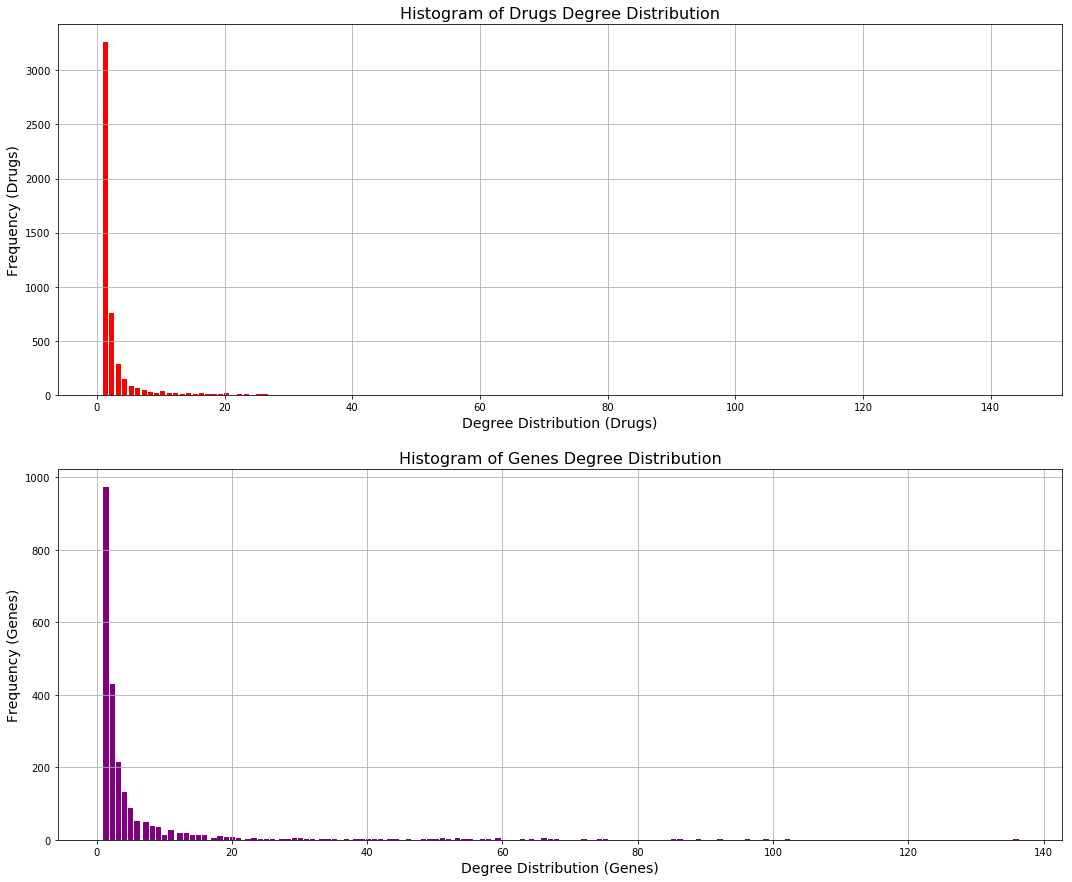

In [22]:
fig = plt.figure(figsize=(18,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
d_ax1 = [item[1] for item in list(d_degree.items())]      ##genes
g_ax2 = [item[1] for item in list(g_degree.items())]    ##drugs

ax1.set_xlabel('Degree Distribution (Drugs)', size=14)
ax1.set_ylabel('Frequency (Drugs)', size=14)
ax1.set_title('Histogram of Drugs Degree Distribution', size=16)
ax1.hist(d_ax1, bins='auto', color='red', rwidth=5, width=0.8)

ax2.set_xlabel('Degree Distribution (Genes)', size=14)
ax2.set_ylabel('Frequency (Genes)', size=14)
ax2.set_title('Histogram of Genes Degree Distribution', size=16)
ax2.hist(g_ax2, bins='auto', color='purple', rwidth=5, width=0.8)


ax1.grid(True)
ax2.grid(True)
#plt.savefig('drug_gene.png')
plt.show()


In [23]:
string = pd.read_csv("HumanStringNet.txt", delimiter="\t", header=None)
string.head()

0      1      2
0   M6PR  PLIN3  0.903
1  ESRRA  SIRT1  0.946
2  ESRRA   NRF1  0.956
3  ESRRA  NRBP1  0.911
4  ESRRA  NR1D1  0.909

In [24]:
string_df = string.rename(columns={0: 'Gene Name', 1: 'Interacting Gene', 2: 'Interaction Weight'})

In [25]:
string_df['Gene_Gene'] = string_df[['Gene Name', 'Interacting Gene']].apply(tuple, axis=1)
string_df.head()

Gene Name Interacting Gene  Interaction Weight       Gene_Gene
0      M6PR            PLIN3               0.903   (M6PR, PLIN3)
1     ESRRA            SIRT1               0.946  (ESRRA, SIRT1)
2     ESRRA             NRF1               0.956   (ESRRA, NRF1)
3     ESRRA            NRBP1               0.911  (ESRRA, NRBP1)
4     ESRRA            NR1D1               0.909  (ESRRA, NR1D1)

In [26]:
edges = string_df["Gene_Gene"].tolist()

In [27]:
G = nx.Graph()
G.add_edges_from(edges)
degree = G.degree()

In [28]:
len(G.edges())

160249

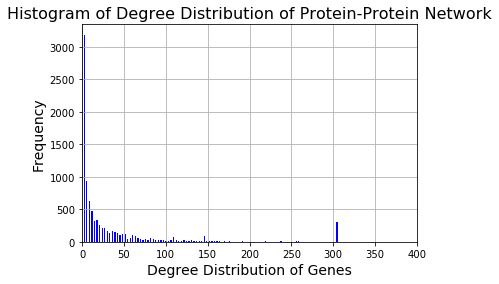

In [29]:
plt.xlabel('Degree Distribution of Genes', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Histogram of Degree Distribution of Protein-Protein Network', size=16)
#plt.ylim(0,2000)
plt.xlim(0,400)

degrees = [item[1] for item in list(degree.items())]

plt.hist(degrees, bins='auto', color='blue', rwidth=0.5)
plt.grid(True)
#plt.savefig('stringnetwork.png')                                         #do savefig before show()!
plt.show()

In [30]:
#string_df.to_csv('stringnetwork.tsv', sep='\t')
#string_df.to_csv('stringnetwork.csv')

In [30]:
max(degree, key=degree.get)  
degree['UBC']

1746

In [31]:
"""Takes the drug as node argument to find the genes that a specific drug works on in graph B(drug-gene graph),
   then, finding the neighboring genes of those genes in G(gene-gene graph).
   Results: list of nodes"""


def neighbor_node(G, node):
    graph = nx.Graph()
    nodes = B.neighbors(node)
    for node in nodes:
        neighbors = []
        if node in G:
            neighbor = G.neighbors(node)
            neighbors.append(neighbor)
            #print(neighbors)
    return neighbors
            
    

In [32]:
"""Takes the drug as node argument to find the genes that a specific drug works on in graph B(drug-gene graph),
   then, finding the neighboring genes of those genes in G(gene-gene graph).
   Results: dictionary key-value pairs."""

def neighbor_nodes(G, node):
    graph = nx.Graph()
    drug_to_gene_nodes = B.neighbors(node)
    neighbors = {}
    
    for dg_node in drug_to_gene_nodes:
        neighbors[dg_node] = {}
        neighbors[dg_node]['Gene Neighbors With'] = []
        
        
        if G.has_node(dg_node):
            gg_nodes = G.neighbors(dg_node)
            
            for ggn in gg_nodes:
                if G.has_node(ggn):
                    neighbors[dg_node]['Gene Neighbors With'].append(ggn)
                
                    
    return(neighbors)

In [33]:
G.has_node('EPB')                            #finds if a node is in a graph

False

In [34]:
drug_list = pd.read_csv("sorted_druglist1.csv")

In [35]:
sorted_druglist = drug_list.sort_values("Drug_list") 

In [37]:
#sorted_druglist.to_csv('sorted_druglist1.csv')

In [36]:
drug_mutation = pd.read_csv("drug_mutation.csv", low_memory=False)

In [39]:
drug_mutation.shape

(1222792, 7)

In [43]:
del drug_mutation["Unnamed: 0"]

In [40]:
genes = drug_mutation["Gene name"]
genes_isnull = pd.isnull(genes)
genes_nulltrue = genes[genes_isnull]
genes_nullfalse = genes[genes_isnull == False]
drug_mutation.dropna(subset=['Gene name'], inplace=True)

In [44]:
drug_mutation.shape

(1204708, 6)

In [45]:
drug_mutation.head()

icgc_donor_id                     Drug_list     Second_drug_list  \
0      DO225076   Docetaxel, Cyclophosphamide  Aromatase Inhibitor   
1      DO225076   Docetaxel, Cyclophosphamide  Aromatase Inhibitor   
2      DO225076   Docetaxel, Cyclophosphamide  Aromatase Inhibitor   
3      DO225076   Docetaxel, Cyclophosphamide  Aromatase Inhibitor   
4      DO225076   Docetaxel, Cyclophosphamide  Aromatase Inhibitor   

  Third_drug_list    gene_affected Gene name  
0             NaN  ENSG00000175471     MCTP1  
1             NaN  ENSG00000175471     MCTP1  
2             NaN  ENSG00000175471     MCTP1  
3             NaN  ENSG00000175471     MCTP1  
4             NaN  ENSG00000175471     MCTP1

In [46]:
drug_mutation2 = sorted_druglist.merge(drug_mutation, how="left")

In [47]:
drug_mutation2.shape

(754031, 24)

In [48]:
drug_mutation3 = drug_mutation2.drop_duplicates(subset=['icgc_donor_id','gene_affected'], keep='first', inplace=False)

In [49]:
drug_mutation3.shape

(152644, 24)

In [46]:
tam = B.neighbors("Tamoxifen")
tam

['ESR1',
 'ESR2',
 'EBP',
 'PRKCA',
 'PRKCB',
 'PRKCD',
 'PRKCE',
 'PRKCG',
 'PRKCI',
 'PRKCQ',
 'PRKCZ']

In [47]:
for gene in tam:
    if gene in G:
        path = nx.single_source_shortest_path(G, gene, 4)
    print(path)
    

{'ESR1': ['ESR1'], 'ESRRA': ['ESR1', 'ESRRA'], 'GNA11': ['ESR1', 'GNA11'], 'KDM4B': ['ESR1', 'KDM4B'], 'MAPK1': ['ESR1', 'MAPK1'], 'XBP1': ['ESR1', 'XBP1'], 'MPG': ['ESR1', 'MPG'], 'STUB1': ['ESR1', 'STUB1'], 'NFKB1': ['ESR1', 'NFKB1'], 'HSPA8': ['ESR1', 'HSPA8'], 'GAPDH': ['ESR1', 'GAPDH'], 'MAPK14': ['ESR1', 'MAPK14'], 'TBP': ['ESR1', 'TBP'], 'NR3C1': ['ESR1', 'NR3C1'], 'MSH2': ['ESR1', 'MSH2'], 'NRBP1': ['ESR1', 'NRBP1'], 'GREB1': ['ESR1', 'GREB1'], 'PRDM2': ['ESR1', 'PRDM2'], 'NR1D1': ['ESR1', 'NR1D1'], 'TUBA4A': ['ESR1', 'TUBA4A'], 'GNAZ': ['ESR1', 'GNAZ'], 'MYOD1': ['ESR1', 'MYOD1'], 'FOXA1': ['ESR1', 'FOXA1'], 'NEDD8': ['ESR1', 'NEDD8'], 'INS': ['ESR1', 'INS'], 'NR1H2': ['ESR1', 'NR1H2'], 'RARA': ['ESR1', 'RARA'], 'NR0B2': ['ESR1', 'NR0B2'], 'MACROD1': ['ESR1', 'MACROD1'], 'IL6': ['ESR1', 'IL6'], 'PAK6': ['ESR1', 'PAK6'], 'RORA': ['ESR1', 'RORA'], 'PTGES3': ['ESR1', 'PTGES3'], 'SGK3': ['ESR1', 'SGK3'], 'GNAO1': ['ESR1', 'GNAO1'], 'PPARA': ['ESR1', 'PPARA'], 'GNA15': ['ESR1', 'GN

{'PRKCZ': ['PRKCZ'], 'NGFR': ['PRKCZ', 'NGFR'], 'IL2RB': ['PRKCZ', 'IL2RB'], 'NFKBIA': ['PRKCZ', 'NFKBIA'], 'PARD6A': ['PRKCZ', 'PARD6A'], 'NFKB1': ['PRKCZ', 'NFKB1'], 'IL2': ['PRKCZ', 'IL2'], 'LNPEP': ['PRKCZ', 'LNPEP'], 'INS': ['PRKCZ', 'INS'], 'NUMBL': ['PRKCZ', 'NUMBL'], 'PEBP1': ['PRKCZ', 'PEBP1'], 'CDH1': ['PRKCZ', 'CDH1'], 'AKT3': ['PRKCZ', 'AKT3'], 'GRB14': ['PRKCZ', 'GRB14'], 'PIK3CA': ['PRKCZ', 'PIK3CA'], 'AKT1': ['PRKCZ', 'AKT1'], 'CGN': ['PRKCZ', 'CGN'], 'PIK3R1': ['PRKCZ', 'PIK3R1'], 'NCF1': ['PRKCZ', 'NCF1'], 'F11R': ['PRKCZ', 'F11R'], 'PRKCI': ['PRKCZ', 'PRKCI'], 'F2RL2': ['PRKCZ', 'F2RL2'], 'NFATC3': ['PRKCZ', 'NFATC3'], 'INSR': ['PRKCZ', 'INSR'], 'CTNNA1': ['PRKCZ', 'CTNNA1'], 'CDC42': ['PRKCZ', 'CDC42'], 'GSK3B': ['PRKCZ', 'GSK3B'], 'NFATC1': ['PRKCZ', 'NFATC1'], 'PAWR': ['PRKCZ', 'PAWR'], 'LCK': ['PRKCZ', 'LCK'], 'GRB2': ['PRKCZ', 'GRB2'], 'JAK1': ['PRKCZ', 'JAK1'], 'PDPK1': ['PRKCZ', 'PDPK1'], 'CTNNB1': ['PRKCZ', 'CTNNB1'], 'DLG1': ['PRKCZ', 'DLG1'], 'NUMB': ['PRKCZ

In [52]:
P = nx.Graph()

P.add_nodes_from(drug_mutation3['icgc_donor_id'], bipartite=2)

P.add_nodes_from(drug_mutation3['Gene name'], bipartite=4)

P.add_edges_from([(row['icgc_donor_id'], row['Gene name']) for idx, row in drug_mutation3.iterrows()])

In [53]:
p, m = bipartite.sets(P)  #p = patients, m = mutated genes 

In [54]:
len(list(m))

39010

In [55]:
drug = drug_mutation3['Drug_list'].drop_duplicates()
d_list = []
for i in drug:
    i_ = str(i).split(',')
    d_list.append(i_)


In [56]:
d_list

[['Anastrozole'],
 ['Anastrozole', 'Fulvestrant', 'Capecitabine', 'Vinorelbine', 'Docetaxel'],
 ['Anastrozole', 'Letrozole'],
 ['Aromatase Inhibitor'],
 ['Cyclophosphamide', ' Methotrexate', ' Fluorouracil'],
 ['Dexrazoxane'],
 ['Docetaxel', 'Cyclophosphamide'],
 ['Docetaxel', 'Doxorubicin', 'Cyclophosphamide'],
 ['Docetaxel', 'Doxorubicin', 'Cyclophosphamide', 'Aromatase Inhibitor'],
 ['Doxorubincin', ' Cyclophosphamide', ' Tamoxifen', ' Aromatase Inhibitor'],
 ['Doxorubincin', 'Cyclophosphamide'],
 ['Doxorubincin', 'Cyclophosphamide', 'Paclitaxel'],
 ['Doxorubincin', 'Cyclophosphamide', 'Paclitaxel', ' Bevacizumab'],
 ['Doxorubincin', 'Cyclophosphamide', 'Paclitaxel', 'Trastuzumab'],
 ['Exemestane'],
 ['Fluorouracil', 'Epirubicin', 'Cyclophosphamide'],
 ['Fluorouracil', 'Epirubicin', 'Cyclophosphamide', 'Docetaxel'],
 ['Fluorouracil',
  'Epirubicin',
  'Cyclophosphamide',
  'Docetaxel',
  'Anastrozole'],
 ['Fluorouracil', 'Epirubicin', 'Cyclophosphamide', 'Tamoxifen'],
 ['Fluorouraci

In [ ]:
pathcdh13 = nx.single_source_shortest_path(G, "ESR1", 3)
path['CDH13']

In [ ]:
esr1_cdh13 = [n for n in nx.all_shortest_paths(G,source='ESR1',target='CDH13')]

In [ ]:
tamoxifen = neighbor_nodes(G, "Tamoxifen")
for k, v in tamoxifen.items():
    for k1, v1 in v.items():
        print(k)
        

#accomplishes the same task as above code.         
#for key in tamoxifen.keys():
    #print(key)

In [ ]:
combined = list(itertools.chain.from_iterable(esr1_chd13))
unique = set(combined)
len(unique)

In [ ]:
for k, v in tamoxifen.items():
    for k1, v1 in v.items():
        if 'CDH13' in v1:
            print("Yes")
        else:
            print("No")